# Copyright and disclaimer

This is our implementation of DiffWave. It is based heavily on the implementation from https://github.com/lmnt-com/diffwave/ but rewritten a bit for our project.

DISCLAIMER: This notebook is only meant for explanatory purposes. The original code can be found in our github, however it is very messy. This notebook contains all the essential code that is nessecary for understanding the implementation, and it is self contatained in principle, but it is nat guaranteed to run. 

The original code had the following Apache License

Copyright 2020 LMNT, Inc. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Helper functions and tools

In [ ]:
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
      super(AttrDict, self).__init__(*args, **kwargs)
      self.__dict__ = self

  def override(self, attrs):
    if isinstance(attrs, dict):
      self.__dict__.update(**attrs)
    elif isinstance(attrs, (list, tuple, set)):
      for attr in attrs:
        self.override(attr)
    elif attrs is not None:
      raise NotImplementedError
    return self

# Train from bottom

In [ ]:
import argparse
import numpy as np
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.distributed import DistributedSampler

import torchaudio
from torchaudio.transforms import MelSpectrogram

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar

from math import sqrt, floor
from glob import glob
from tqdm import tqdm
from datetime import timedelta

In [ ]:
base_params = dict(
    # Training params
    batch_size=16,
    learning_rate=2e-4,
    max_grad_norm=80.,

    # Data params
    sample_rate=22050,
    n_mels=80,
    n_fft=1024,
    hop_samples=256,
    crop_mel_frames=62,  # Probably an error in paper.

    # Model params
    residual_layers=30,
    residual_channels=64,
    dilation_cycle_length=10,
    unconditional = False,
    noise_schedule=np.linspace(1e-4, 0.05, 50).tolist(),
    inference_noise_schedule=[0.0001, 0.001, 0.01, 0.05, 0.2, 0.5],

    # unconditional sample len
    audio_len = 22050*5, # unconditional_synthesis_samples
    
    data_dir_root = '/dtu/blackhole/11/155505/audio', # the root dir of the data files
    spectrogram_dir_root = '/dtu/blackhole/11/155505/spectrograms', # the root dir of the spectrogram files
    upsampler_target_dir_root = '/dtu/blackhole/11/155505/upsampler_targets', # the root dir of the upsampler target files
    generated_audio_dir_root = '/dtu/blackhole/11/155505/generated_audio', # the root dir of the generated audio files
    generated_spectrogram_dir_root = '/dtu/blackhole/11/155505/generated_spectrograms', # the root dir of the generated spectrogram files
    project_dir_root = '', # the root dir of the project files
    checkpoint_dir_root = 'experiments', # the root dir of the checkpoint files
    results_dir_root = 'experiments',
    model_evaluator_results_dir = 'model_evaluator_results',

    train_dir = 'NST_dataset/train', #relative to data_dir
    test_dir = 'NST_dataset/test',  #relative to data_dir
    val_dir = 'NST_dataset/val', #relative to data_dir

    spectrogram_full_dir = 'full',
    spectrogram_dir = 'full', # the version of spectrograms to use relative to spectrogram_dir_root


    num_workers = 4,
    fp16 = True,
    load_data_to_ram = False,
    accelerator = 'gpu',
    gradient_clip_val = 0,
    checkpoint_name = None,
    downscale = None
)

params = AttrDict(base_params)

## Diffwave object and dependensies

In [ ]:
def Conv1d(*args, **kwargs):
    layer = nn.Conv1d(*args, **kwargs)
    nn.init.kaiming_normal_(layer.weight)
    return layer


class DiffusionEmbedding(nn.Module):
    def __init__(self, max_steps):
        super().__init__()
        self.register_buffer('embedding', self._build_embedding(max_steps), persistent=False)
        self.projection1 = nn.Linear(128, 512)
        self.projection2 = nn.Linear(512, 512)

    def forward(self, diffusion_step):
        if diffusion_step.dtype in [torch.int32, torch.int64]:
            x = self.embedding[diffusion_step]
        else:
            x = self._lerp_embedding(diffusion_step)
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _lerp_embedding(self, t):
        low_idx = torch.floor(t).long()
        high_idx = torch.ceil(t).long()
        low = self.embedding[low_idx]
        high = self.embedding[high_idx]
        return low + (high - low) * (t - low_idx)

    def _build_embedding(self, max_steps):
        steps = torch.arange(max_steps).unsqueeze(1) # [T,1]
        dims = torch.arange(64).unsqueeze(0)         # [1,64]
        table = steps * 10.0**(dims * 4.0 / 63.0)    # [T,64]
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table


class SpectrogramUpsampler(pl.LightningModule):
    def __init__(self, n_mels, downscale=None, params=None, pretrained_model=None):
        super().__init__()
        
        if params is not None:
            self.params = params
        
        self.pretrained_model = pretrained_model
        
        self.loss_fn = nn.MSELoss()
        self.use_downscale = downscale is not None # bool
        if self.use_downscale:
            scale = int(1 / downscale) # e.g.: 1, 2, 4, 8
            assert scale in [1, 2, 4, 8]
            self.conv_downscale = nn.ConvTranspose2d(1, 1, [2 * scale, 2 * scale], stride=[scale, scale], padding=[int(scale // 2), int(scale // 2)])
        self.conv1 = nn.ConvTranspose2d(1, 1, [3, 32], stride=[1, 16], padding=[1, 8])
        self.conv2 = nn.ConvTranspose2d(1, 1, [3, 32], stride=[1, 16], padding=[1, 8])

        self.save_hyperparameters()
        
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        if self.use_downscale:
            x = self.conv_downscale(x)
            x = F.leaky_relu(x, 0.4)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.4)
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.4)
        x = torch.squeeze(x, 1)
        return x
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.params.learning_rate)
    
    def process_batch(self, batch):
        
        downscaled, original = batch['downscaled'].to(self.device), batch['original'].to(self.device)
        
        x = self(downscaled)
        y = self.pretrained_model.spectrogram_upsampler(original).detach()
        loss = self.loss_fn(x, y)
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss


class ResidualBlock(nn.Module):
    def __init__(self, n_mels, residual_channels, dilation):
        '''
        :param n_mels: inplanes of conv1x1 for spectrogram conditional
        :param residual_channels: audio conv
        :param dilation: audio conv dilation
        :param uncond: disable spectrogram conditional
        '''
        super().__init__()
        
        self.dilated_conv = Conv1d(residual_channels, 2 * residual_channels, 3, padding=dilation, dilation=dilation)
        self.diffusion_projection = nn.Linear(512, residual_channels)
        
        self.conditioner_projection = Conv1d(n_mels, 2 * residual_channels, 1)

        self.output_projection = Conv1d(residual_channels, 2 * residual_channels, 1)

    def forward(self, x, diffusion_step, conditioner):

        diffusion_step = self.diffusion_projection(diffusion_step).unsqueeze(-1)
        y = x + diffusion_step
            
        conditioner = self.conditioner_projection(conditioner)
        y = self.dilated_conv(y) + conditioner

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)

        y = self.output_projection(y)
        residual, skip = torch.chunk(y, 2, dim=1)
        return (x + residual) / sqrt(2.0), skip


class DiffWave(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        
        # saveconda install -c conda-forge tensorflow hyperparams for load
        self.save_hyperparameters()
        self.params = params
        
        self.diffusion_embedding = DiffusionEmbedding(len(params.noise_schedule))
        self.spectrogram_upsampler = SpectrogramUpsampler(params.n_mels)
        self.residual_layers = nn.ModuleList([
            ResidualBlock(params.n_mels, params.residual_channels, 2**(i % params.dilation_cycle_length))
            for i in range(params.residual_layers)
        ])
        self.input_projection = Conv1d(1, params.residual_channels, 1)
        self.skip_projection = Conv1d(params.residual_channels, params.residual_channels, 1)
        self.output_projection = Conv1d(params.residual_channels, 1, 1)
        
        # fill the input with zeros
        nn.init.zeros_(self.output_projection.weight)
        
        # train params
        self.loss_fn = nn.L1Loss()
        beta = np.array(self.params.noise_schedule)
        noise_level = np.cumprod(1 - beta)
        self.noise_level = torch.tensor(noise_level.astype(np.float32))
        self.autocast = torch.cuda.amp.autocast(enabled=params.get('fp16', False))

    def forward(self, audio, diffusion_step, spectrogram):
        x = audio.unsqueeze(1)
        x = self.input_projection(x)
        x = F.relu(x)

        diffusion_step = self.diffusion_embedding(diffusion_step)
        
        spectrogram = self.spectrogram_upsampler(spectrogram)

        skip = torch.zeros_like(x)
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_step, spectrogram)
            skip += skip_connection

        x = skip / sqrt(len(self.residual_layers))
        x = self.skip_projection(x)
        x = F.relu(x)
        x = self.output_projection(x)
        return x
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.params.learning_rate)
    
    def process_batch(self, batch):
            
        audio, spectrogram = batch['audio'], batch['spectrogram']

        N, T = audio.shape
        device = audio.device
        self.noise_level = self.noise_level.to(device)

        with self.autocast:
            t = torch.randint(0, len(self.params.noise_schedule), [N], device=audio.device)
            noise_scale = self.noise_level[t].unsqueeze(1)
            noise_scale_sqrt = torch.sqrt(noise_scale)
            noise = torch.randn_like(audio)
            noisy_audio = noise_scale_sqrt * audio + torch.sqrt(1.0 - noise_scale) * noise

            predicted = self(noisy_audio, t, spectrogram)
            loss = self.loss_fn(noise, predicted.squeeze(1))
        
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        with torch.no_grad():
            # Change in notation from the DiffWave paper for fast sampling.
            # DiffWave paper -> Implementation below
            # --------------------------------------
            # alpha -> talpha
            # beta -> training_noise_schedule
            # gamma -> alpha
            # eta -> beta
            
            spectrogram = batch['spectrogram']
            
            # get device
            device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
            
            training_noise_schedule = np.array(self.params.noise_schedule)
            inference_noise_schedule = np.array(self.params.inference_noise_schedule)

            talpha = 1 - training_noise_schedule
            talpha_cum = np.cumprod(talpha)

            beta = inference_noise_schedule
            alpha = 1 - beta
            alpha_cum = np.cumprod(alpha)

            T = []
            for s in range(len(inference_noise_schedule)):
                for t in range(len(training_noise_schedule) - 1):
                    if talpha_cum[t+1] <= alpha_cum[s] <= talpha_cum[t]:
                        twiddle = (talpha_cum[t]**0.5 - alpha_cum[s]**0.5) / (talpha_cum[t]**0.5 - talpha_cum[t+1]**0.5)
                        T.append(t + twiddle)
                        break
            T = torch.tensor(T, dtype=torch.float).unsqueeze(1) # to tensor and create batch dim


            if len(spectrogram.shape) == 2: # Expand rank 2 tensors by adding a batch dimension.
                spectrogram = spectrogram.unsqueeze(0)
            spectrogram = spectrogram.to(device)
            if self.params.downscale is not None: downscale = self.params.downscale
            else: downscale = 1.0
            audio = torch.randn(spectrogram.shape[0], int(self.params.hop_samples * spectrogram.shape[-1] / downscale), device=device)

            for n in range(len(alpha) - 1, -1, -1):
                c1 = 1 / alpha[n]**0.5
                c2 = beta[n] / (1 - alpha_cum[n])**0.5
                audio = c1 * (audio - c2 * self(audio, T[n], spectrogram).squeeze(1))
                if n > 0:
                    noise = torch.randn_like(audio)
                    sigma = ((1.0 - alpha_cum[n-1]) / (1.0 - alpha_cum[n]) * beta[n])**0.5
                    audio += sigma * noise
                audio = torch.clamp(audio, -1.0, 1.0)
                
        return audio


def get_pretrained_model(model_path, params):
    
    use_cuda = torch.cuda.is_available()
    # get device
    device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

    # init model
    model = DiffWave(params).to(device)
    
    #checkpoint = torch.load(model_path, map_location=None if use_cuda else torch.device('cpu'))
    #model.load_state_dict(checkpoint['model'])
    model.load_from_checkpoint(model_path)
    
    model.eval()
    return model

## DataModules

### DataModules for spectrogram to speech training

In [ ]:


def prepare_data(params, audio_file_paths, audio_dir, spec_file_paths, spec_dir):
    """
    Preprocess audio files and save them as spectrograms.

    Parameters
    ----------
    * params: AttrDict
    * audio_file_paths: list of str - paths to the audio files
    * audio_dir: str - directory containing the audio files (only used for printing the progress bar)
    * spec_file_paths: list of str - paths to the spectrogram files - where the spectrograms will be saved
    * spec_dir: str - directory containing the spectrogram files (only used for printing the progress bar)

    """

    ingnored_idx = []

    mel_args = {
            'sample_rate': params.sample_rate,
            'win_length': params.hop_samples * 4,
            'hop_length': params.hop_samples,
            'n_fft': params.n_fft,
            'f_min': 20.0,
            'f_max': params.sample_rate / 2.0,
            'n_mels': params.n_mels,
            'power': 1.0,
            'normalized': True,
    }

    downscale = params.get("downscale", None)

    if downscale is not None:
        mel_args['win_length'] = int(mel_args['win_length'] / downscale)
        mel_args['hop_length'] = int(mel_args['hop_length'] / downscale)
        mel_args['n_fft'] = int(mel_args['n_fft'] / downscale)
        mel_args['n_mels'] = int(mel_args['n_mels'] * downscale)

    
    mel_spec_transform = MelSpectrogram(**mel_args)
    
    for i in tqdm(range(len(audio_file_paths)), desc=f'Preprocessing {audio_dir}'):
        audio_file_path = audio_file_paths[i]
        spec_file_path = spec_file_paths[i]
        assert os.path.exists(audio_file_path), f"Audio file not found: {audio_file_path}, {audio_dir}, {spec_dir}"
        if os.path.exists(spec_file_path):
            continue
        
        audio, sr = torchaudio.load(audio_file_path)
        audio = torch.clamp(audio[0], -1.0, 1.0)

        if params.sample_rate != sr:
            raise ValueError(f'Invalid sample rate: {sr} != {params.sample_rate} (True).')

        with torch.no_grad():
            spectrogram = mel_spec_transform(audio)
            
            if spectrogram.shape[1] < params.crop_mel_frames:
                ingnored_idx.append(i)
            
            spectrogram = 20 * torch.log10(torch.clamp(spectrogram, min=1e-5)) - 20
            spectrogram = torch.clamp((spectrogram + 100) / 100, 0.0, 1.0)
            np.save(spec_file_path, spectrogram.detach().cpu().numpy())

    return ingnored_idx 


class SpeechDataset(Dataset):
    def __init__(self, audio_dir, spec_dir):
        super().__init__()
        self.audio_dir = audio_dir
        self.spec_dir = spec_dir
        self.audio_file_paths = np.array([os.path.realpath(f) for f in glob(f"{audio_dir}/**/*.wav", recursive=True)])
        self.audio_filenames = np.array([os.path.relpath(f, self.audio_dir) for f in self.audio_file_paths])
        self.spec_filenames = np.array([f'{f}.spec.npy' for f in self.audio_filenames])
        self.spec_file_paths = np.array([os.path.join(spec_dir, f) for f in self.spec_filenames])
        self.ignored_files = []

        for f in self.spec_file_paths:
            os.makedirs(os.path.dirname(f))

    def __repr__(self):
        return f'{self.__class__.__name__}(dirs = {self.audio_dir}, {self.spec_dir}, {len(self)} items, {len(self.ignored_files)} ignored)'

    def split(self, split_ratio=0.1):
        def mask_set(set, mask):
            set.audio_file_paths = self.audio_file_paths[mask]
            set.audio_filenames = self.audio_filenames[mask]
            set.spec_filenames = self.spec_filenames[mask]
            set.spec_file_paths = self.spec_file_paths[mask]

        n_split = floor(len(self) * split_ratio)
        mask = np.random.permutation(len(self)) < n_split
        set1 = self.__class__(self.audio_dir, self.spec_dir)
        set2 = self.__class__(self.audio_dir, self.spec_dir)
        mask_set(set1, mask)
        mask_set(set2, ~mask)
        return set1, set2


    def ignore_item(self, idx):
        self.ignored_files.append(self.audio_file_paths[idx])
        del self.audio_file_paths[idx]
        del self.audio_filenames[idx]
        del self.spec_filenames[idx]
        del self.spec_file_paths[idx]


    def __len__(self):
        return len(self.audio_filenames)
    
    def _load_one_item(self, idx):
        audio_file_path = self.audio_file_paths[idx]
        spec_file_path = self.spec_file_paths[idx]
        signal, _ = torchaudio.load(audio_file_path)
        spectrogram = np.load(spec_file_path).T
        assert signal.shape[0] == 1, f"Only mono audio is supported, found {signal.shape}"
        return signal.squeeze(0), spectrogram

    def __getitem__(self, idx):
        signal, spectrogram  = self._load_one_item(idx)
        return {
            'audio': signal,
            'spectrogram': spectrogram
        }   

    def prepare_data(self, params):
        ignored_idx = prepare_data(params, self.audio_file_paths, self.audio_dir, self.spec_file_paths, self.spec_dir)
        for i in ignored_idx:
            self.ignore_item(i)   

class SpeechDataModule(pl.LightningDataModule):
    def __init__(self, params):
        
        super().__init__()
        self.params = params
        
        # this is for improving speed
        self.num_workers = self.params.get('num_workers', os.cpu_count())
        
        # this is for the dataloader
        self.loader_kwargs = {
            'batch_size': params.batch_size,
            'collate_fn': self.collate,
            'num_workers': self.num_workers,
            'pin_memory': True,
            'drop_last': True
        }
    
    def setup(self, stage):
        # Assign Train/val split(s) for use in Dataloaders
        if stage == 'fit':
            audio_path_train = os.path.join(self.params.data_dir_root, self.params.train_dir)
            spec_path_train = os.path.join(self.params.spectrogram_dir_root, self.params.spectrogram_dir, self.params.train_dir)
            # if (self.params.val_dir is None) and False:
            #     # load train set - split train set into train and val
            #     self.val_set, self.train_set = SpeechDataset(audio_path_train, spec_path_train).split(self.params.val_size)
            # else:
            #     # load train and val set
            audio_path_val = os.path.join(self.params.data_dir_root, self.params.val_dir)
            spec_path_val = os.path.join(self.params.spectrogram_dir_root, self.params.spectrogram_dir, self.params.val_dir)
            
            self.val_set = SpeechDataset(audio_path_val, spec_path_val)
            self.train_set = SpeechDataset(audio_path_train, spec_path_train)

            self.val_set.prepare_data(self.params)
            self.train_set.prepare_data(self.params)
            
        if stage == 'test':
            audio_path_test = os.path.join(self.params.data_dir_root, self.params.test_dir)
            spec_path_test = os.path.join(self.params.spectrogram_dir_root, self.params.spectrogram_dir, self.params.test_dir)
            self.test_set = SpeechDataset(audio_path_test, spec_path_test)
            self.test_set.prepare_data(self.params)

    
    def collate(self, minibatch):
        
        samples_per_frame = self.params.hop_samples
        for record in minibatch:
            
            # Filter out records that aren't long enough.
            assert self.params.crop_mel_frames <= len(record['spectrogram'])

            start = random.randint(0, record['spectrogram'].shape[0] - self.params.crop_mel_frames)
            end = start + self.params.crop_mel_frames
            record['spectrogram'] = record['spectrogram'][start:end].T

            start *= samples_per_frame
            end *= samples_per_frame
            record['audio'] = record['audio'][start:end]
            record['audio'] = np.pad(record['audio'], (0, (end-start) - len(record['audio'])), mode='constant')

        audio = np.stack([record['audio'] for record in minibatch])
        spectrogram = np.stack([record['spectrogram'] for record in minibatch])
        
        return {
            'audio': torch.from_numpy(audio),
            'spectrogram': torch.from_numpy(spectrogram),
        }
    
    def train_dataloader(self):
        return DataLoader(self.train_set, shuffle=True, **self.loader_kwargs)

    def val_dataloader(self):
        return DataLoader(self.val_set, shuffle=False, **self.loader_kwargs)

    def test_dataloader(self):
        return DataLoader((self.test_set), shuffle=False, **self.loader_kwargs(self.test_set))


### zoom spectrograms

In [ ]:
from scipy.ndimage import zoom

def zoom_spec(spec, reduction_factor):
    return zoom(zoom(spec, reduction_factor), 1/reduction_factor)

if __name__ == "__main__":
    reduction_factor = 0.5
    
    spec_reduced_dir = os.path.join(params.spectrogram_dir_root, str(reduction_factor))
    spec_full_dir = os.path.join(params.spectrogram_dir_root, params.spectrogram_full_dir)

    spec_paths = glob(f"{spec_full_dir}/**/*.spec.npy", recursive=True)
    for spec_path in tqdm(spec_paths):
        spec_reduced_path = os.path.join(spec_reduced_dir, os.path.relpath(spec_path, spec_full_dir))
        if os.path.exists(spec_reduced_path): continue
        spec = np.load(spec_path)
        spec_reduced = zoom_spec(spec, reduction_factor)

        os.makedirs(os.path.dirname(spec_reduced_path), exist_ok=True)
        np.save(spec_reduced_path, spec_reduced)

### DataModule for downsampled spectrogram to conditioner training

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, state, downscale, params):
        super().__init__()
        self.state = state # 'train', 'val', 'test'
        self.downscale = downscale
        self.params = params
        
        self.downscale_dir = os.path.join(self.params.spectrogram_dir_root,f'downscale_{downscale}', state)
        self.original_dir = os.path.join(self.params.spectrogram_dir_root,self.params.spectrogram_dir_full, state)
        
        filenames = glob(f'{self.original_dir}/**/*.spec.npy', recursive=True)
        self.filenames = [os.path.relpath(f, self.original_dir) for f in filenames]
            
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        downscaled_path = os.path.join(self.downscale_dir, self.filenames[idx])
        original_path = os.path.join(self.original_dir, self.filenames[idx])
        downscaled = torch.from_numpy(np.load(downscaled_path).T)
        original = torch.from_numpy(np.load(original_path).T)
        return {
            'downscaled': downscaled,
            'original': original
        }


class SpectrogramDataModule(pl.LightningDataModule):
    def __init__(self, params, data_dir, downscale):
        super().__init__()
        self.data_dir = data_dir
        self.downscale = downscale
        self.scale = int(1 // downscale)
        assert self.scale in [1, 2, 4, 8, 16, 32]
        self.params = params
        
        # this is for improving speed
        self.num_workers = self.params.get('num_workers', os.cpu_count())
        
        # this is for the dataloader
        self.loader_kwargs = {
            'batch_size': params.batch_size,
            'num_workers': self.num_workers,
            'collate_fn': self.collate,
            'pin_memory': True,
            'drop_last': True
        }
  
    def setup(self, stage):
        # Assign Train/val split(s) for use in Dataloaders
        if stage == 'fit':
            
            self.train_set = SpectrogramDataset('train', self.downscale, self.params)
            self.val_set = SpectrogramDataset('val', self.downscale, self.params)
            
        if stage == 'test':
            
            self.test_set = SpectrogramDataset('test', self.downscale, self.params)
    
    
    def collate(self, minibatch):
        
        downscale_lenth = int(self.params.crop_mel_frames * self.downscale)
        buffer = self.scale if self.scale > 1 else 0
        for record in minibatch:
            
            # Filter out records that aren't long enough.
            assert downscale_lenth <= len(record['downscaled']) + buffer

            start = random.randint(0, record['downscaled'].shape[0] - (downscale_lenth + buffer))
            end = start + downscale_lenth
            record['downscaled'] = record['downscaled'][start:end].T

            start *= self.scale
            end = start + self.scale * downscale_lenth
            record['original'] = record['original'][start:end].T
        

        downscaled = np.stack([record['downscaled'] for record in minibatch])
        original = np.stack([record['original'] for record in minibatch])
        
        return {
            'downscaled': torch.from_numpy(downscaled),
            'original': torch.from_numpy(original),
        }
    
    def train_dataloader(self):
        return DataLoader(self.train_set, shuffle=True, **self.loader_kwargs)

    def val_dataloader(self):
        return DataLoader(self.val_set, shuffle=False, **self.loader_kwargs)

    def test_dataloader(self):
        return DataLoader(self.test_set, shuffle=False, **self.loader_kwargs)

### Helper functions for running upsampler training

In [ ]:
def prepare_data(params, data_dir, savedir, downscale=None):
    filenames = glob(f'{data_dir}/**/*.wav', recursive=True)
        
    mel_args = {
            'sample_rate': params.sample_rate,
            'win_length': params.hop_samples * 4,
            'hop_length': params.hop_samples,
            'n_fft': params.n_fft,
            'f_min': 20.0,
            'f_max': params.sample_rate / 2.0,
            'n_mels': params.n_mels,
            'power': 1.0,
            'normalized': True,
    }

    if downscale is not None:
        mel_args['win_length'] = int(mel_args['win_length'] / downscale)
        mel_args['hop_length'] = int(mel_args['hop_length'] / downscale)
        mel_args['n_fft'] = int(mel_args['n_fft'] / downscale)
        mel_args['n_mels'] = int(mel_args['n_mels'] * downscale)
    
    mel_spec_transform = MelSpectrogram(**mel_args)
    
    for filename in tqdm(filenames, desc='Preprocessing'):
        
        if os.path.exists(f'{filename}.spec.npy'):
            continue
        
        audio, sr = torchaudio.load(filename)
        
        #if audio.shape[0] != 1:
        #    raise ValueError(f'Audio signal does not seem to be mono, channels = {audio.shape[0]}.')
        
        audio = torch.clamp(audio[0], -1.0, 1.0)

        if params.sample_rate != sr:
            raise ValueError(f'Invalid sample rate {sr} != {params.sample_rat} (True).')

        with torch.no_grad():
            spectrogram = mel_spec_transform(audio)
            
            if spectrogram.shape[1] < params.crop_mel_frames:
                continue
            
            spectrogram = 20 * torch.log10(torch.clamp(spectrogram, min=1e-5)) - 20
            spectrogram = torch.clamp((spectrogram + 100) / 100, 0.0, 1.0)
            save_path = f'{savedir}/{filename[len(data_dir):]}.spec.npy'
            save_folder = os.path.dirname(save_path)
            # create folder if not exists
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            np.save(save_path, spectrogram.cpu().numpy())


def create_conditions(model, data_dir, save_dir):
    
    with torch.no_grad():
    
        for file in tqdm(glob(f'{data_dir}/**/*.spec.npy', recursive=True), desc='Creating conditions'):
            # load spectrogram
            spectrogram = np.load(file)
            
            device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
            
            spectrogram = torch.from_numpy(spectrogram).unsqueeze(0).to(device)
            
            # get conditions
            conditions = model.spectrogram_upsampler(spectrogram)
            
            # save conditions
            save_path = f'{save_dir}/{file[len(data_dir):]}'
            save_folder = os.path.dirname(save_path)
            # create folder if not exists
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            np.save(save_path, conditions.cpu().numpy())

## Main loop for running spectrogram to speech experiment

In [ ]:
class StoreGradNormCallback(pl.Callback):

    def on_before_optimizer_step(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule", optimizer, opt_idx: int):
        
        def compute_grad_norm(model):
            if model.measure_grad_norm:
                grad_norm = 0.0
                for p in list(filter(lambda p: p.grad is not None, model.parameters())):
                    grad_norm += torch.linalg.norm(p.grad.data).detach()**2
            return grad_norm**0.5

        pl_module.log('grad_2_norm', compute_grad_norm(pl_module), on_step=True, on_epoch=True, prog_bar=True, logger=True)


def get_trainer(params, max_epochs, checkpoint_dir, results_dir):

    # store grad norm
    store_grad_norm_callback = StoreGradNormCallback()

    #costum proqress bar
    progress_bar = TQDMProgressBar(refresh_rate=100)

    # save model every 1 hour
    checkpoint_callback_time = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename='time-{epoch}-{val_loss:.6f}',
        every_n_epochs=15,
        save_top_k=-1,
        )
    
    # save k best end of epoch models
    checkpoint_callback_top_k = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename='k-{epoch}-{val_loss:.6f}',
        save_top_k=3,
        monitor='val_loss',
        mode='min'
        )
    
    # create logger
    logger = CSVLogger(
        save_dir=results_dir,
        name='log',
        flush_logs_every_n_steps=10
        )
    

    if params.accelerator == 'gpu':
        assert torch.cuda.is_available(), "CUDA is not available."


    trainer = pl.Trainer(
        callbacks=[checkpoint_callback_time, checkpoint_callback_top_k, store_grad_norm_callback, progress_bar], # runs at the end of every train loop
        log_every_n_steps=10,
        max_epochs=max_epochs,
        accelerator=params.accelerator,
        # devices=1,
        logger=logger,
        gradient_clip_val=params.gradient_clip_val,
        # track_grad_norm=2,
    )

    return trainer


def fit_model(model: DiffWave, params, experiment_name, global_seed, max_epochs):

    checkpoint_dir = os.path.join(params.project_dir_root, params.checkpoint_dir_root, f'{experiment_name}_{global_seed}')
    os.makedirs(checkpoint_dir)
    results_dir = os.path.join(params.project_dir_root, params.results_dir_root, f'{experiment_name}_{global_seed}')
    os.makedirs(results_dir)
    exp_script_dir = os.path.join(results_dir, 'experiment_scripts')
    os.makedirs(exp_script_dir)

    pl.seed_everything(global_seed, workers=True)
    data = SpeechDataModule(params=params)
    trainer = get_trainer(params, max_epochs, checkpoint_dir, results_dir)
    ckpt_path = os.path.join(checkpoint_dir, params.checkpoint_name) if params.checkpoint_name is not None else None
    if ckpt_path is not None:
        assert os.path.exists(ckpt_path), f"checkpoint path {ckpt_path} does not exist"
    trainer.fit(model, data, ckpt_path=ckpt_path,)




def main():

    #########################################################################
    # -------------- specify the options for the experiment -----------------

    experiment_name = 'experiment'
    global_seed = 42
    max_epochs = 100000
    checkpoint_name = "k-epoch=53-val_loss=0.037580.ckpt" # if None or commented out, train from scratch

    #params.learning_rate = 5e-5
    params.gradient_clip_val = 80.
    # params.spectrogram_dir = "0.5" # specficy the spectrogram directory to use


    ckpt_path = os.path.join(params.project_dir_root, params.checkpoint_dir_root, f'{experiment_name}_{global_seed}', checkpoint_name)


    checkpoint = torch.load(ckpt_path)#, map_location=None if use_cuda else torch.device('cpu'))
    model = DiffWave(params, measure_grad_norm=True)
    model.load_state_dict(checkpoint['state_dict'])
    
    # load the model somehow
    

    # ----------------- don't change anything below this line ---------------
    #########################################################################


    fit_model(model, params, experiment_name, global_seed, max_epochs)
    

## Main loop for running upsampler training

In [ ]:

def main(model_path, params, data_search_string, downscale):
    
    # model = get_pretrained_model(model_path=model_path, params=params)
    
    upsampler_model = SpectrogramUpsampler(None, downscale=downscale, params=params)
    
    # data_paths = glob(data_search_string, recursive=True)
    # data_paths = [path[len(data_search_string):] for path in data_paths]
    #for downscale in [0.125]:
    #    prepare_data(params, data_search_string, f"data/spectrograms/downscale_{downscale}", downscale)
    # create_conditions(model, "data/spectrograms/original", "data/conditions")
    
    # upsampler training 
    data = SpectrogramDataModule(params=params,
                            data_dir='data/spectrograms/',
                            downscale=downscale
                            )
    
    save_dir = f'upsamplers/{downscale}'
    
    # save k best end of epoch models
    checkpoint_callback_top_k = ModelCheckpoint(
    	dirpath=save_dir,
    	filename='best-{epoch}-{val_loss:.6f}',
    	save_top_k=5,
    	monitor='val_loss',
    	mode='min'
    	)
    
    logger = CSVLogger(
        save_dir=save_dir,
        name='log',
        flush_logs_every_n_steps=10
        )
    
    use_cuda = torch.cuda.is_available()
    accelerator = 'gpu' if use_cuda else 'cpu'
    
    trainer = pl.Trainer(
        callbacks=[checkpoint_callback_top_k], # runs at the end of every train loop
        log_every_n_steps=10,
        max_epochs=2,
        accelerator=accelerator,
        # devices=1,
        logger=logger,
    )
    
    trainer.fit(upsampler_model, data)
    

if __name__ == '__main__':
    params = AttrDict(base_params)
    
    model_path = './k-epoch=53-val_loss=0.037580.ckpt' # get pytorch model in directory
    data_search_string = 10 * '../' + 'dtu/blackhole/11/155505/audio/NST_dataset/'
    
    pretrained_model = get_pretrained_model(model_path=model_path, params=params)
    
    for downscale in [1]:
        main(model_path, params, data_search_string, downscale)



# Evaluation

# Comparing models

In [ ]:

from params import params, base_params, AttrDict
from upsampler_data_module import UpsamplerDataModule, UpsamplerDataset
from speech_datamodule import SpeechDataModule, SpeechDataset, prepare_data
import os
from diffwave_model import DiffWave
from tqdm import tqdm
import numpy as np
import torch
import torchaudio
import multiprocessing as mp

from Upsampler_data.create_data import SpectrogramUpsampler
from diffwave_model import DiffWave



EVAL_PATH = params.test_dir

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ORIGINAL_AUDIO_PATH = os.path.join(params.data_dir_root, EVAL_PATH)
ORIGINAL_SPEC_PATH = os.path.join(params.spectrogram_dir_root, params.spectrogram_full_dir, EVAL_PATH)

class ModelEvaluator:
    def __init__(self, model: DiffWave, experiment_dir, spectrogram_dir=None, n_samples=100, downscale=1.0):
        # init parameters
        self.model = model
        self.experiment_dir = experiment_dir
        self.downscale = downscale
        self.n_samples = n_samples
  
        self.start = 128
        self.end = 128 + 64

        self.spectrogram_dir = spectrogram_dir if spectrogram_dir is not None else experiment_dir
        self.path = os.path.join(params.project_dir_root, params.model_evaluator_results_dir, experiment_dir)
        os.makedirs(self.path, exist_ok=True)

        self.generated_audio_path = os.path.join(params.generated_audio_dir_root, experiment_dir, EVAL_PATH)
        self.generated_spec_path = os.path.join(params.generated_spectrogram_dir_root, experiment_dir, EVAL_PATH)

        self.original_dataset = SpeechDataset(ORIGINAL_AUDIO_PATH, ORIGINAL_SPEC_PATH)
        self.original_dataset.prepare_data(params) # to remove
        
        rng = np.random.default_rng(seed=42)
        self.idx = rng.choice(len(self.original_dataset), self.n_samples, replace=False)

        self.reduced_spec_file_paths = np.array([os.path.join(params.spectrogram_dir_root, self.spectrogram_dir, EVAL_PATH, f) for f in self.original_dataset.spec_filenames])
        self.generated_audio_file_paths = np.array([os.path.join(self.generated_audio_path, f) for f in self.original_dataset.audio_filenames])
        self.generated_spec_file_paths = np.array([os.path.join(self.generated_spec_path, f) for f in self.original_dataset.spec_filenames])
        
        for f in self.generated_audio_file_paths:
            os.makedirs(os.path.dirname(f), exist_ok=True)
        for f in self.generated_spec_file_paths:
            os.makedirs(os.path.dirname(f), exist_ok=True)
        
        self.audio_generated = False
        self.spec_generated = False
        self.loss = None
        
        self.sanity_check()


    def sanity_check(self):
        assert os.path.exists(self.original_dataset.audio_file_paths[0]), f"{self.original_dataset.audio_file_paths[0]}"
        assert os.path.exists(self.original_dataset.spec_file_paths[0]), f"{self.original_dataset.spec_file_paths[0]}"
        assert os.path.exists(self.reduced_spec_file_paths[0]), f"{self.reduced_spec_file_paths[0]}"

    def __repr__(self):
        ret = f"ModelEvaluator for {self.path} with {len(self)} samples\n"
        ret += f"generated_audio_path: {self.generated_audio_path}\n"
        ret += f"generated_spec_path: {self.generated_spec_path}\n"
        ret += f"original_dataset_audio[0]: {self.original_dataset.audio_file_paths[0]}\n"
        ret += f"original_dataset_spec[0]: {self.original_dataset.spec_file_paths[0]}\n"
        ret += f"reduced_file_paths[0]: {self.reduced_spec_file_paths[0]}\n"
        ret += f"generated_audio_file_paths[0]: {self.generated_audio_file_paths[0]}\n"
        ret += f"generated_spec_file_paths[0]: {self.generated_spec_file_paths[0]}\n"
        return ret


    def __len__(self):
        return len(self.original_dataset)

    def evaluate(self, overwrite=False, parallel=False):
        self.generate_audio_from_spectrograms(parallel)
        self.generate_spectrograms_from_generated_audio()
        self.compute_loss(overwrite=overwrite)

    def compute_loss(self, overwrite=False):
        assert self.audio_generated and self.spec_generated, "Audio and spectrograms must be generated before evaluation can be performed"
        if os.path.exists(os.path.join(self.path, "loss.npy")) and not overwrite:
            self.loss = np.load(os.path.join(self.path, "loss.npy"))
        else:
            loss = []
            for i in tqdm(self.idx, desc=f"Computing loss {self.experiment_dir}"):
                generated_spec = np.load(self.generated_spec_file_paths[i])
                original_spec = np.load(self.original_dataset.spec_file_paths[i])
                original_spec = original_spec[:, self.start:self.end]
                assert generated_spec.shape[0] == original_spec.shape[0], "Spectrograms must have the same number of n_mels"
                length = min(generated_spec.shape[1], original_spec.shape[1])
                generated_spec = generated_spec[:, :length]
                original_spec = original_spec[:, :length]
                loss.append(np.mean((generated_spec - original_spec)**2))
            self.loss = np.array(loss)
            np.save(os.path.join(self.path, "loss.npy"), self.loss)

    def generate_audio_from_spectrograms(self, parallel=False):
        # generate audio from spectrograms
        (start, end) = (int(self.start*self.downscale), int(self.end*self.downscale)) if self.downscale is not None else (self.start, self.end)

        for i in tqdm(self.idx, desc=f"Generating audio from spectrograms of length {end-start} from {self.experiment_dir}"):
            spec_path = self.reduced_spec_file_paths[i]
            audio_path = self.generated_audio_file_paths[i]
            if not os.path.exists(audio_path):

                spec = np.load(spec_path)[:, start:end]
                spec = torch.from_numpy(spec).to(DEVICE)
                audio = self.model.predict_step({"spectrogram": spec}, None)
                print(audio.shape)
                torchaudio.save(audio_path, audio, params.sample_rate)
    
        self.audio_generated = True

    def generate_spectrograms_from_generated_audio(self):
        # generate spectrograms from audio
        assert self.audio_generated, "Audio must be generated before spectrograms can be generated from audio"
        
        prepare_data(
                    params,
                    self.generated_audio_file_paths[self.idx],
                    self.generated_audio_path,
                    self.generated_spec_file_paths[self.idx],
                    self.generated_spec_path,
                    )
        
        self.spec_generated = True
            


model_paths = ["models_for_comparison/k-epoch=53-val_loss=0.037580.ckpt", ""]



downscales = [None, 0.5, 0.25, 0.25]

model_path = "models_for_comparison/k-epoch=53-val_loss=0.037580.ckpt"

upsampler_paths = [
                    None,
                    "Upsampler_data/upsamplers/0.5/best-epoch=1-val_loss=0.000007.ckpt",
                    "Upsampler_data/upsamplers/0.25/best-epoch=1-val_loss=0.000004.ckpt",
                    None
]

exp_names = [f"downscale_{downscale}" if downscale is not None else params.spectrogram_full_dir for downscale in downscales]
exp_names[-1] += "_untrained"
spec_dirs = exp_names[:-1] + [exp_names[-2]]

models = []
model_evaluators = []

for downscale, upsampler_path, exp_name, spec_dir in zip(downscales, upsampler_paths, exp_names, spec_dirs):

    base_params["downscale"] = downscale
    base_params["spectrogram_dir"] = f'downscale_{downscale}' if downscale is not None else base_params["spectrogram_full_dir"]
    temp_params = AttrDict(base_params)

    # generate the spectrograms
    dm = SpeechDataModule(temp_params)
    dm.setup('test')

    # get the model
    ckpt = torch.load(model_path, map_location=DEVICE)
    model = DiffWave(temp_params)
    model.load_state_dict(ckpt['state_dict'])

    # get the upsampler
    if downscale is not None:
        
        if "untrained" in exp_name: spec_ups = SpectrogramUpsampler(None, downscale, temp_params).to(DEVICE)
        else: spec_ups = SpectrogramUpsampler.load_from_checkpoint(upsampler_path).to(DEVICE)
        
        model.spectrogram_upsampler = spec_ups

    # get the evaluator
    evaluator = ModelEvaluator(model, exp_name, spec_dir, 100, downscale=downscale)
    #model, experiment_dir, spectrogram_dir, n_samples, downscale
    evaluator.evaluate(overwrite=False, parallel=False)




In [ ]:

result_paths = glob(f"{params.model_evaluator_results_dir}/**/*loss.npy", recursive=True)
experiment_names = [os.path.basename(os.path.dirname(p)) for p in result_paths]
results = [np.load(p) for p in result_paths]

for result, experiment_name in zip(results, experiment_names):
    print(experiment_name)
    print(f"{result.mean():.4f} +- {1.96*result.std():.4f}")
    print()

# Training curves

## the results from the poster

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from glob import glob

In [2]:
def plot_epoch(ax, df, markersize=2, window=100):
    
    df_val_epoch = df[['epoch', 'val_loss_epoch']].dropna(subset='val_loss_epoch').set_index('epoch')
    df_train_epoch = df[['epoch', 'train_loss_epoch']].dropna(subset='train_loss_epoch').set_index('epoch')
    
    ax.plot(df_train_epoch, '.', markersize=markersize, label='train')
    ax.plot(df_val_epoch, '.', markersize=markersize, label='val')
    
    ax.plot(df_train_epoch.rolling(window=window).mean(), label=f'train (window size {window})')
    ax.plot(df_val_epoch.rolling(window=window).mean(), label=f'val (window size {window})')


def plot_step(ax, df, markersize=2, window=1000, alpha=1):
    
    df_train_step = df[['step', 'train_loss_step']].dropna(subset='train_loss_step').set_index('step')
    
    ax.plot(df_train_step, '.', markersize=markersize, label='train', alpha=alpha)
    
    ax.plot(df_train_step.rolling(window=window).mean(), label=f'train (window size {window})')

def plot_test(ax, df, markersize=2, label=None):
    
    df_test_epoch = df[['epoch', 'test_loss_epoch']].dropna(subset='test_loss_epoch').set_index('epoch')
    
    ax.plot(df_test_epoch, '.', markersize=markersize, label=label)

def upsampler_plot(path):
    df = pd.read_csv(path)
    mean_activation = 0.0592486

    plt.plot(np.sqrt(df[['step','train_loss_step']].dropna(subset='train_loss_step').set_index('step')) / mean_activation, '.', markersize=3, label='Train step loss')
    plt.plot(np.sqrt(df[['step','val_loss_epoch']].dropna(subset='val_loss_epoch').set_index('step')) / mean_activation, 'o', label='Val epoch loss')
    plt.legend()
    plt.xlabel('Step')
    plt.ylabel('Relative RMSE')
    plt.title(f'Losses for {path.split("/")[1]}x upsampler')
    # show y value for last step
    plt.annotate(f"{np.sqrt(df['val_loss_epoch'].dropna().iloc[-1]) / mean_activation:.3f}", xy=(df['step'].dropna().iloc[-1], np.sqrt(df['val_loss_epoch'].dropna().iloc[-1]) / mean_activation), xytext=(df['step'].dropna().iloc[-1], np.sqrt(df['val_loss_epoch'].dropna().iloc[-1]) / mean_activation))
    # plt.yscale('log')
    plt.show()

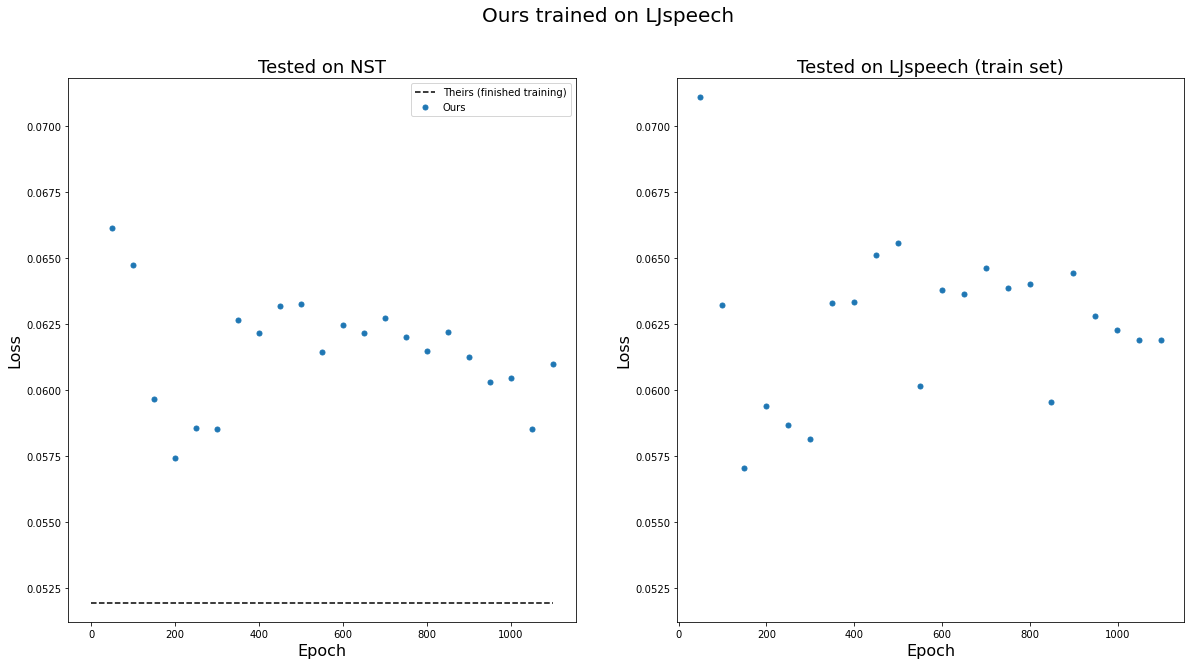

In [3]:
test_paths = glob('test/*/*/*/metrics.csv')
test_paths = list(filter(lambda x: '42' not in x, test_paths))

path = test_paths[2]

df = pd.read_csv(path)

test_data, test = path.split('\\')[1:3]
test_data = test_data.split('_')[0]
test = ' '.join(test.split('_')[:-1])

fig = plt.figure(figsize=(20, 10))
fig.suptitle(f'Ours trained on LJspeech', fontsize=20)

ax = fig.add_subplot(121)

ax.set_title('Tested on NST', fontsize=18)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)

theirs = pd.read_csv(test_paths[1])['test_loss_epoch'].dropna().iloc[0]
ax.plot([0, max(df['epoch'].dropna())], [theirs, theirs], label='Theirs (finished training)', color='black', linestyle='--')
plot_test(ax, df, markersize=10, label='Ours')
ax.legend()

ax1 = fig.add_subplot(122)
ax1.set_title('Tested on LJspeech (train set)', fontsize=18)
ax1.set_xlabel('Epoch', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
path = test_paths[0]
df = pd.read_csv(path)
plot_test(ax1, df, markersize=10)

y_min = min(ax.get_ylim()[0], ax1.get_ylim()[0])
y_max = max(ax.get_ylim()[1], ax1.get_ylim()[1])

ax.set_ylim(top=y_max, bottom=y_min)
ax1.set_ylim(top=y_max, bottom=y_min)

_ = plt.plot()

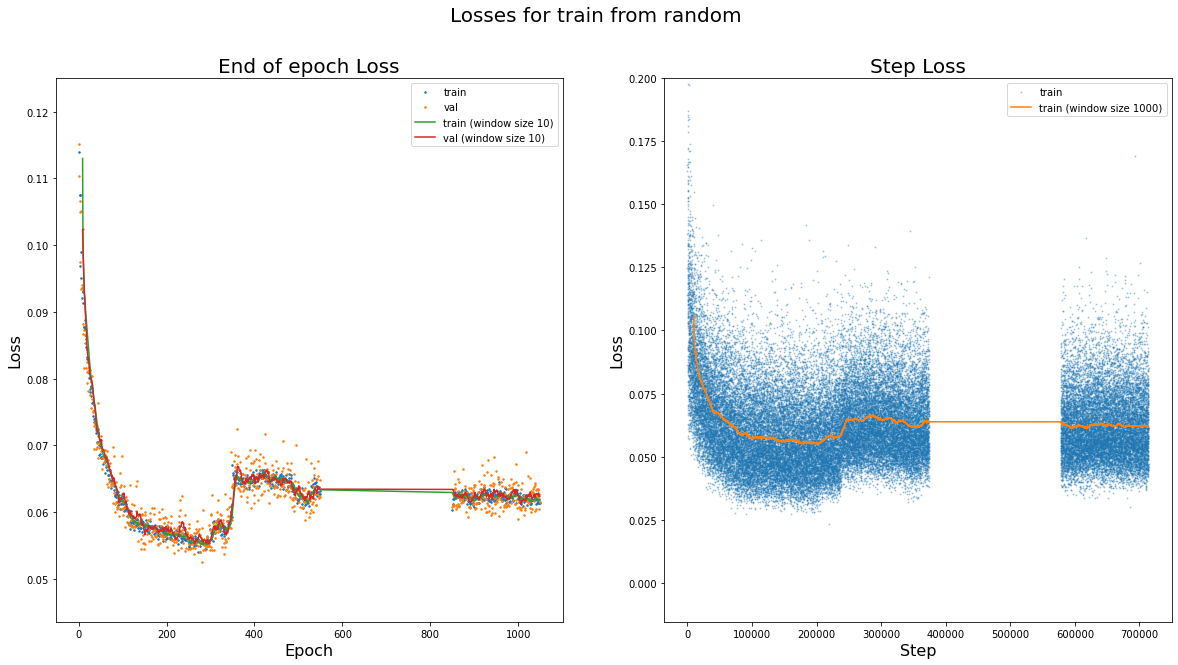

In [4]:
metric_paths = glob('./spectrogram/danish/*/checkpoints/log/*/metrics.csv')

df0 = pd.read_csv(metric_paths[0])
df0 = df0.iloc[:65249+1]

df1 = pd.read_csv(metric_paths[1])
df1 = df1.iloc[:14499+1]

df2 = pd.read_csv(metric_paths[2])
df2 = df2.iloc[:28999+1]

df = pd.concat([df0, df1, df2])

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Losses for train from random'.format(0), fontsize=20)

ax0 = fig.add_subplot(121)
plot_epoch(ax0, df, window=10, markersize=3)
ax0.set_title('End of epoch Loss', fontsize=20)
ax0.set_xlabel('Epoch', fontsize=16)
ax0.set_ylabel('Loss', fontsize=16)
ax0.set_ylim(top=0.125)
ax0.legend()

ax1 = fig.add_subplot(122)
plot_step(ax1, df, window=1000, alpha=0.3)
ax1.set_title('Step Loss', fontsize=20)
ax1.set_xlabel('Step', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_ylim(top=0.2)
ax1.legend()

_ = plt.plot()

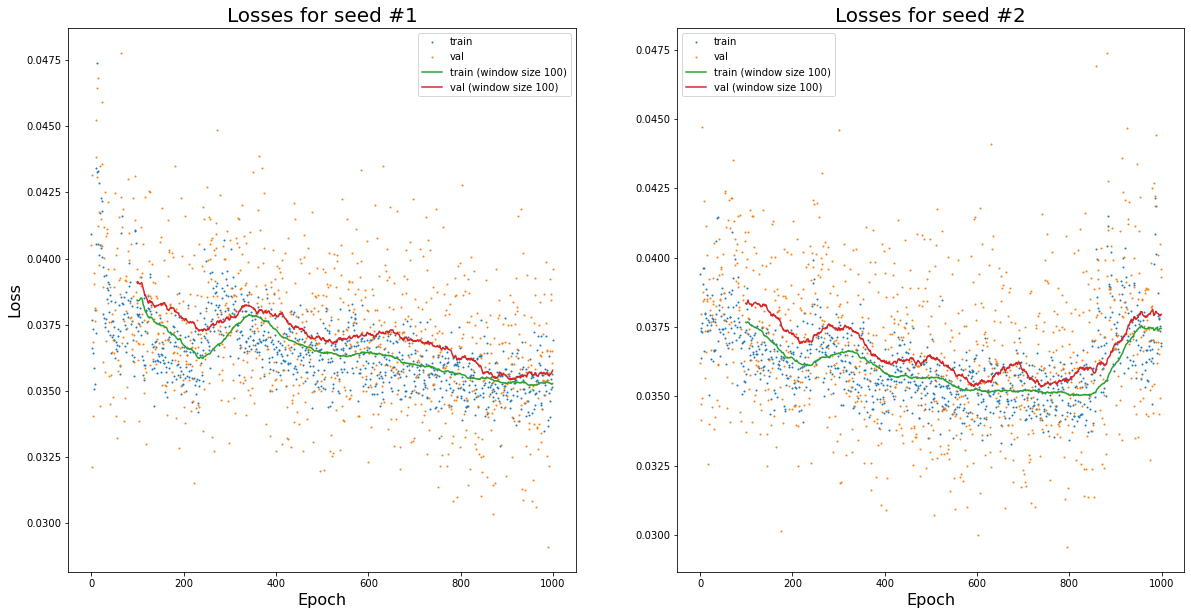

In [5]:
seeds = [int(metric_path.split('\\')[1].split('_')[-1]) for metric_path in metric_paths[3:]]
dfs = [pd.read_csv(metric_path) for metric_path in metric_paths[3:]]

fig = plt.figure(figsize=(20, 10))

ax0 = fig.add_subplot(121)
plot_epoch(ax0, dfs[0])
ax0.set_title('Losses for seed #1', fontsize=20)
ax0.set_xlabel('Epoch', fontsize=16)
ax0.set_ylabel('Loss', fontsize=16)
ax0.legend()

ax1 = fig.add_subplot(122)
plot_epoch(ax1, dfs[1])
ax1.set_title('Losses for seed #2', fontsize=20)
ax1.set_xlabel('Epoch', fontsize=16)
ax1.legend()

_ = plt.plot()

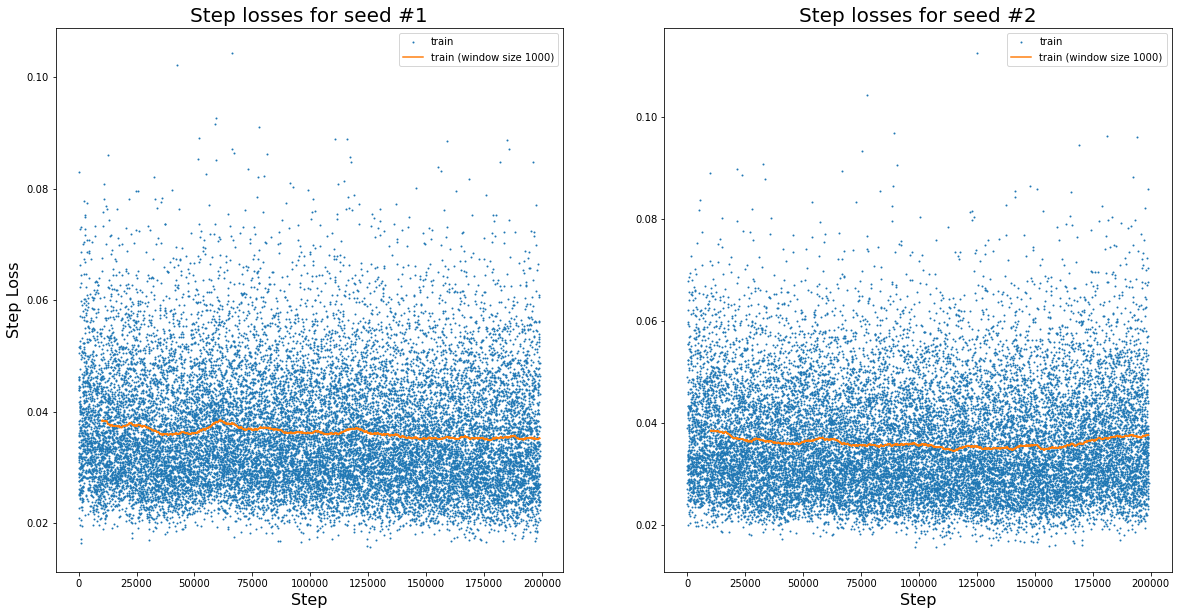

In [6]:
fig = plt.figure(figsize=(20, 10))

ax0 = fig.add_subplot(121)
plot_step(ax0, dfs[0])
ax0.set_title('Step losses for seed #1', fontsize=20)
ax0.set_xlabel('Step', fontsize=16)
ax0.set_ylabel('Step Loss', fontsize=16)
ax0.legend()

ax1 = fig.add_subplot(122)
plot_step(ax1, dfs[1])
ax1.set_title('Step losses for seed #2', fontsize=20)
ax1.set_xlabel('Step', fontsize=16)
ax1.legend()

_ = plt.plot()

## new plots

### training upsampler

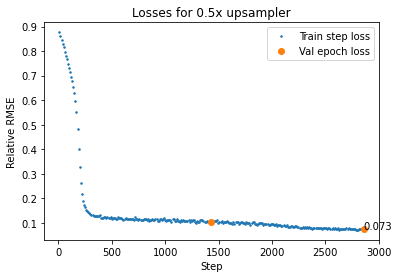

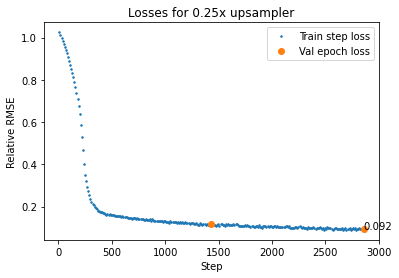

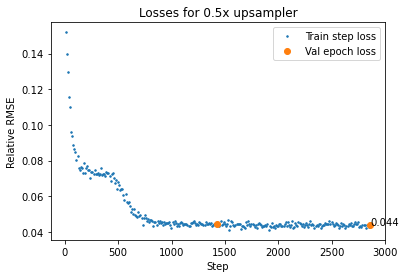

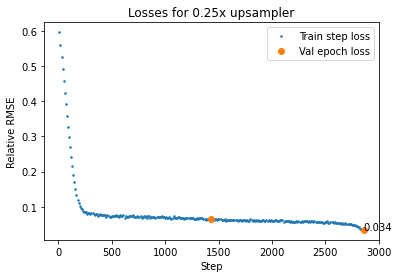

In [7]:
paths = [f'upsamplers/{downscale}/log/version_{i}/metrics.csv' for i in (0, 1) for downscale in (0.5, 0.25)]

for p in paths:
    upsampler_plot(p)

### from scratch

In [ ]:
#%%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


experiments = [
    # (experiment_name, version, end_epoch, offset)
    # ("from_bottom_v3_42", "version_1"),
    # ("from_bottom_v3_42", "version_2"),

    # ("from_bottom_v8_42", "version_0", 239, 0),
    # ("from_bottom_v8_42", "version_1", 404, 0),
    # ("from_bottom_v8_42", "version_2", None, 0),

    ("from_bottom_v8_2_42", "version_0", 239, 0),
    ("from_bottom_v8_2_42", "version_1", 404, 0),
    ("from_bottom_v8_2_42", "version_2", 479, 0),
    ("from_bottom_v8_2_42", "version_5", None, 480),

    # ("zoom_0_5_42", "version_0", None, 0),
    ]

hist_split_epoch = []


versions = {}
for exp in experiments:
    if exp[0] not in versions:
        versions[exp[0]] = [exp[1].split("_")[-1]]
    else:
        versions[exp[0]].append(exp[1].split("_")[-1])
        assert int(versions[exp[0]][-2]) < int(versions[exp[0]][-1]), "versions are not in order"

assert len(versions) == 1, "only one experiment name allowed"

title = f"experiment: {experiments[0][0]}"

metrics_paths = [os.path.join("experiments", exp[0], "log", exp[1], "metrics.csv") for exp in experiments]

data = [pd.read_csv(path) for path in metrics_paths]

for i in range(len(data)):
    # filter out the epochs after end_epoch
    data[i]['epoch'] = data[i]['epoch'] + experiments[i][3]
    if experiments[i][2] is not None:
        data[i] = data[i][data[i]['epoch'] <= experiments[i][2]]

# concatenate the data
data = pd.concat(data, axis=0)

#%%


start_step = 0
start_epoch = 0

scale = 3/4

fig = plt.figure(figsize=(10*scale,5*scale))


ax = fig.add_subplot(2,2,1)
# step_data = data[['step','grad_2_norm_step']].dropna()
epoch_data = data[['epoch','grad_2_norm_epoch']].dropna()
# ax.plot(step_data['step'], step_data['grad_2_norm_step'], ',', label='step')
ax.plot(epoch_data['epoch'], epoch_data['grad_2_norm_epoch'])
ax.set_title('Gradient norm epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient $L2$-norm')
# ax.legend()


ax = fig.add_subplot(1,2,2)

# add vertical line at 480+53
ax.axvline(x=480+53, color='r', linestyle='--', label='epoch 533')

# ax = fig.add_subplot(2,2,4)
epoch_data = data[['epoch','val_loss_epoch']].dropna()
ax.plot(epoch_data['epoch'], epoch_data['val_loss_epoch'], label='Validation loss')

epoch_data = data[['epoch','train_loss_epoch']].dropna()
ax.plot(epoch_data['epoch'], epoch_data['train_loss_epoch'], label='Train loss')

ax.set_title('Training curve')
ax.set_ylim(min(np.min(data[['train_loss_epoch', 'val_loss_epoch']]))-0.005, 0.095)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (unweighted $D_{KL}$)')
ax.legend()


step_data = data[['step', 'epoch', 'grad_2_norm_step']].dropna()
ax = fig.add_subplot(2,2,3)
ax.set_title('Gradient norm step distribution')

step_data_split = []

    # n_splits = 4
    # split_idx = int(len(step_data)/n_splits)+1
    # for i in range(n_splits):
    #     # ax = fig.add_subplot(2,n_splits*2,n_splits*2+i+1)
    #     step_data_split.append(step_data.iloc[i*split_idx:(i+1)*split_idx])


split_epoch = hist_split_epoch
split_epoch = [step_data.iloc[0]['epoch']] + split_epoch
split_epoch.append(step_data.iloc[-1]['epoch']+1)

for i in range(len(split_epoch)-1):
    step_data_split.append(step_data[(step_data['epoch'] >= split_epoch[i]) & (step_data['epoch'] < split_epoch[i+1])])

for i in range(len(step_data_split)):
    ax.hist(step_data_split[i]['grad_2_norm_step'], bins=100, density=True, alpha = 0.4, label=f'Epochs {step_data_split[i].iloc[0]["epoch"]:.0f} to {step_data_split[i].iloc[-1]["epoch"]:.0f}')
for i in range(len(step_data_split)):
    ax.hist(step_data_split[i]['grad_2_norm_step'], bins=100, density=True, histtype='step', linewidth=1, edgecolor='black')



ax.set_xlabel('Gradient $L2$-norm')
ax.set_ylabel('Density')

ax.legend()



fig.tight_layout()

fig.savefig("poster_report/from_bottom_v8_2_42.png", dpi=300)

plt.show()
